<h3> 0) Download the Libraries</h3> 

Before using the program you will need to download the required librearies using "pip install \<library name\>"
<ul>
    <li>uciml repo</li>
    <li>sklearn</li>
    <li>pandas</li>
    <li>numpy</li>
    <li>matplotlib</li>
    <li>seaborn</li>
    <li>tensorflow</li>
    <li>keras</li>
    <li>tf_keras</li>
</ul>

<h3> 1) importing the libraries and disabling warnings</h3> 
Below is a list of the imports for the program as well the warning supression used in order to prevent some minor warning that have occured

In [13]:
import os
import warnings
import logging
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
import tensorflow as tf
warnings.filterwarnings('ignore')
tf.get_logger().setLevel(logging.ERROR)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score,ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier
from tensorflow.python.keras.models import *
from tensorflow.keras.layers import LSTM,Dense,Embedding
from tensorflow.keras.preprocessing import sequence
from ucimlrepo import fetch_ucirepo

<h3>2) Loading and organizing data</h3>
The dataset is stored online so the first thing to do is to fetch it using the appropriate call. once that is done you can pull the X and Y variables from the dataset and organize them accordingly. from there the values of each is taken from the dataset and saved

In [14]:
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets

X=X.values
ytemp=y.values.ravel()
print("-----X-----\n",X)
print("-----Y-----\n",ytemp)

-----X-----
 [[1.799e+01 1.038e+01 1.228e+02 ... 2.654e-01 4.601e-01 1.189e-01]
 [2.057e+01 1.777e+01 1.329e+02 ... 1.860e-01 2.750e-01 8.902e-02]
 [1.969e+01 2.125e+01 1.300e+02 ... 2.430e-01 3.613e-01 8.758e-02]
 ...
 [1.660e+01 2.808e+01 1.083e+02 ... 1.418e-01 2.218e-01 7.820e-02]
 [2.060e+01 2.933e+01 1.401e+02 ... 2.650e-01 4.087e-01 1.240e-01]
 [7.760e+00 2.454e+01 4.792e+01 ... 0.000e+00 2.871e-01 7.039e-02]]
-----Y-----
 ['M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'
 'M' 'B' 'B' 'B' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'
 'M' 'B' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'B' 'M' 'B' 'B' 'B' 'B' 'B' 'M'
 'M' 'B' 'M' 'M' 'B' 'B' 'B' 'B' 'M' 'B' 'M' 'M' 'B' 'B' 'B' 'B' 'M' 'B'
 'M' 'M' 'B' 'M' 'B' 'M' 'M' 'B' 'B' 'B' 'M' 'M' 'B' 'M' 'M' 'M' 'B' 'B'
 'B' 'M' 'B' 'B' 'M' 'M' 'B' 'B' 'B' 'M' 'M' 'B' 'B' 'B' 'B' 'M' 'B' 'B'
 'M' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'M' 'M' 'M' 'B' 'M' 'M' 'B' 'B' 'B'
 'M' 'M' 'B' 'M' 'B' 'M' 'M' 'B' 'M' 'M' 'B' 'B' 'M' 'B

Once the dataset is loaded into the variabels, the y variable is changed from characters of 'M' being Malignant and 'B' being Benign into 1 for Malignant and 0 for Benign. The main reason for doing this is that there was an error with Long Short Term Memory (LSTM) where it is unable to use the Y-axis as a character meaning it had to be switched to an integer. from there the X and Y varaibles are converted into Numpy Arrays.

In [15]:
#conversion from 'M' and 'B' to 0 and 1 for LSTM
y=[]
for i in ytemp:
    if(i == 'M'):
        y.append(1)
    else:
        y.append(0)
X = np.array(X)
y= np.array(y)
print("-----X-----\n",X)
print("-----Y-----\n",y)

-----X-----
 [[1.799e+01 1.038e+01 1.228e+02 ... 2.654e-01 4.601e-01 1.189e-01]
 [2.057e+01 1.777e+01 1.329e+02 ... 1.860e-01 2.750e-01 8.902e-02]
 [1.969e+01 2.125e+01 1.300e+02 ... 2.430e-01 3.613e-01 8.758e-02]
 ...
 [1.660e+01 2.808e+01 1.083e+02 ... 1.418e-01 2.218e-01 7.820e-02]
 [2.060e+01 2.933e+01 1.401e+02 ... 2.650e-01 4.087e-01 1.240e-01]
 [7.760e+00 2.454e+01 4.792e+01 ... 0.000e+00 2.871e-01 7.039e-02]]
-----Y-----
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 1 0 1 1
 0 1 0 1 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 1 1 0 1 0 1 1 0 1 1 0 0 1 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 1 1 1 0 1
 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 0 0 1 0 1 1 1 1 0 0 1 1 0 0
 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 

<h3>3) Calculations</h3>
The <strong>Calculations</strong> function is used by all of the processes and each of the k-fold iterations in order to calculate each of the metrics. The function is given 4 varaibles: the confusion matrix named <strong>matrix</strong>, an integer named <strong>Brier</strong> which is the sum of the y test and y predict variables, an integer <strong>y_pred_len</strong> which is the length of the y prediction, and <strong>avg</strong> which is a boolean for whether the given variables is the mean of the matrixes. Using these variables the function calculates each of the metrics that are later used. If the avg variable is True (meaning it is the average) then it doesnt do the calculations for the Brier score, otherwise it divides the given brier number by the length of the y prediction length. Once the calculations are finished then the calculations are organized and returned as a pandas dataframe.

In [16]:
#calculations for each measurement
def Calculations(matrix, Brier,y_pred_len,avg,auc):
    tp,fp,fn,tn = matrix.ravel()
    fpr = fp / (tn + fp)
    fnr = fn / (tp + fn)
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    precision = tp /(tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * ((precision * recall)/(precision+recall))
    accuracy = (tp + tn)/(tp+tn+fp+fn)
    error = (fp + fn)/(tp+tn+fp+fn)
    bacc = (tpr + tnr)/2
    tss = (tpr - fpr)
    hss = ((2*(tp * tn - fp * fn))/((fp+fn)*(fn+tn)+(tp+fp)*(fp+tn)))
    if(avg==False):
        Brier = Brier/y_pred_len
    return pd.DataFrame([{"TP":tp,"TN":tn,"FP":fp,"FN":fn,"TPR": tpr, "TNR": tnr,"FPR": fpr, "FNR":fnr, "Precision": precision, "Accuracy":accuracy, "Recall":recall ,"F1_measure":f1,"Error_rate":error,"BACC":bacc,"TSS":tss,"HSS":hss,"Brier_Score":Brier, "AUC":auc}])

<h3>4) Creating the storage for the dataframes and matrixes</h3>
The neighbors is set for K Nearest Neighbor (KNN) and a random seed is set for Long Short Term Memory (LSTM). Next the K-fold is set to split the x and y variables into 10 equally sized arrays and shuffles the variables before splitting them. An empty dataframe and an empty array is created for each of the 3 methods to store each of the results into.

In [17]:
neighbors = np.arange(1, 9) 
tf.random.set_seed(7)

kf = KFold(n_splits=10, shuffle=True, random_state=42)
knn_metrics_list = pd.DataFrame()
knn_matrix=[]
rf_metrics_list = pd.DataFrame()
rf_matrix=[]
lstm_metrics_list = pd.DataFrame()
lstm_matrix=[]

print(knn_metrics_list)
print("empty matrix: ",knn_matrix)

Empty DataFrame
Columns: []
Index: []
empty matrix:  []


<h3>5) Calculating each of the models</h3>
The X and Y variables are split into two parts each, two X variables for <strong>X_Test</strong> and for <strong>X_Train</strong> and two Y variables for <strong>y_test</strong> and for <strong>y_train</strong>

<h4>5.1) KNN calculation</h4>
First the program runs a for loop for each of the neighbors which was specified earlier and then creates a model each time. once the model is created, the model predicts the output given the X_test variable. Once the prediction is made, the brier score is calculated as well as the area under the curve (AUC) score, both of which are then sent to the calculate function to organize into a dataframe. Finally everything is stored into an array that holds all of iterations of the dataframes and confusion matrixs. 

--------------------------K nearest Neighbor--------------------------


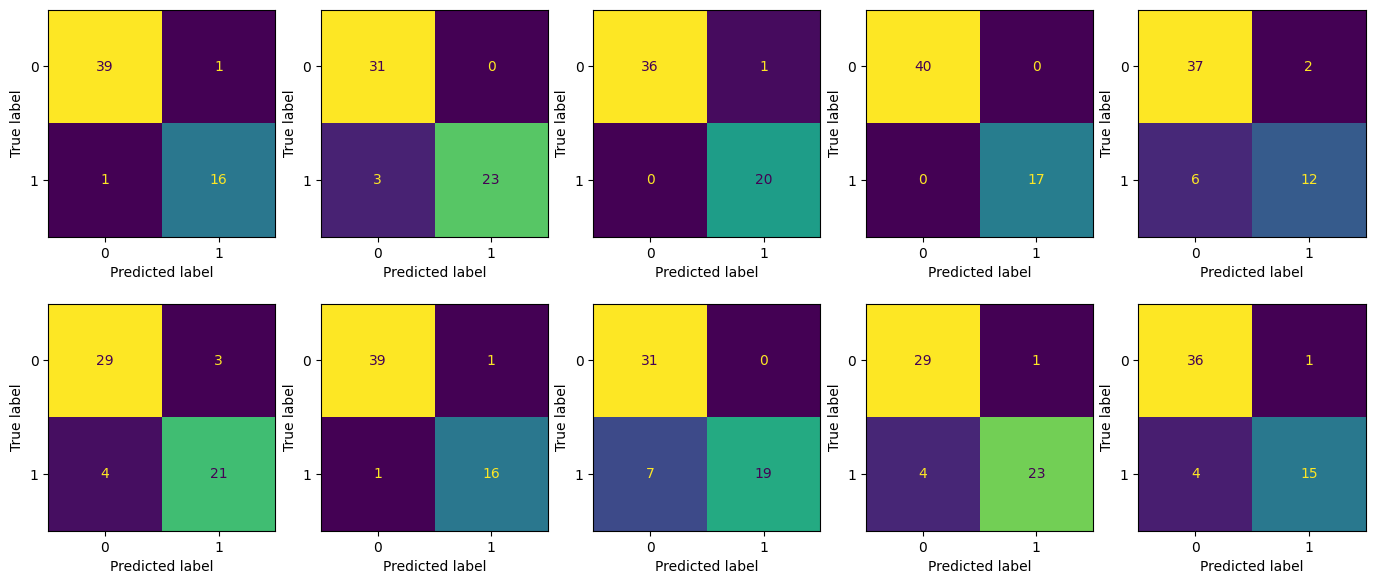

In [18]:
row=0
col=0
fig, ax = plt.subplots(2, 5)
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #KNN calculation
    for i, k in enumerate(neighbors): 
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
    knny_pred = knn.predict(X_test)
    knnBrier=0
    for i in range(len(knny_pred)):
        if(knny_pred[i].round() != y_test[i]):
            knnBrier+=1
    knncm = confusion_matrix(y_test,knny_pred.round())
    knn_matrix.append(knncm)
    knnauc=roc_auc_score(y_test, knny_pred)
    knn_metrics_list=pd.concat([knn_metrics_list,Calculations(knncm,knnBrier,len(knny_pred),False,knnauc)])

    fig.set_figwidth(17)
    fig.set_figheight(7)  
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = knncm, display_labels = [0, 1]).plot(ax=ax[col][row],colorbar=False)

    row+=1
    if(row==5):
        col+=1
        row=0
print("--------------------------K nearest Neighbor--------------------------")

<h4>5.2) Random Forest Calculation</h4>
The model for random forest is created such there there is one estimator for each row in the dataset. The prediction is then made using the X_test data and the brier score and AUC are then calculated and sent to the Calculation function to be organized into a dataframe. the confusion matrix and the dataframe is then saved and stored in an array for later

--------------------------Random Forest--------------------------


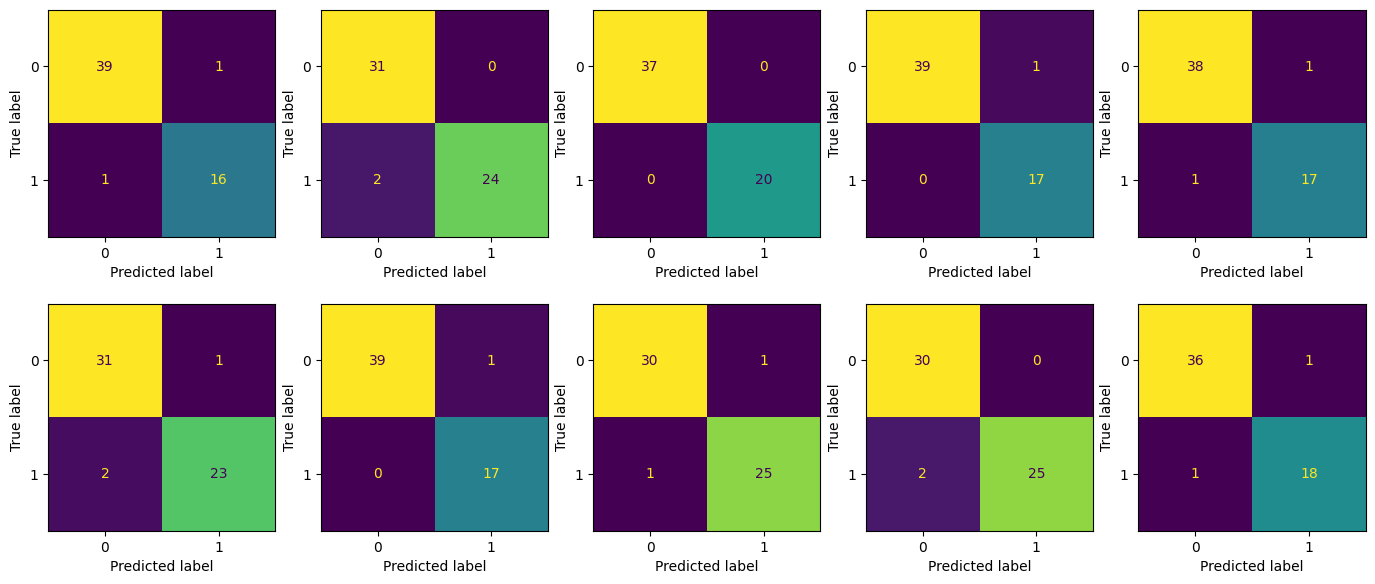

In [19]:
row=0
col=0
fig, ax = plt.subplots(2, 5)
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #random forest calculation
    clf = RandomForestClassifier(n_estimators = 569)
    clf.fit(X_train, y_train)
    rfy_pred = clf.predict(X_test)
    rfBrier=0
    for i in range(len(rfy_pred)):
        if(rfy_pred[i].round() != y_test[i]):
            rfBrier+=1
    rfcm = confusion_matrix(y_test,rfy_pred.round())
    rf_matrix.append(rfcm)
    rfauc=roc_auc_score(y_test, rfy_pred)
    rf_metrics_list=pd.concat([rf_metrics_list,Calculations(rfcm,rfBrier,len(rfy_pred),False,rfauc)])

    fig.set_figwidth(17)
    fig.set_figheight(7) 
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = rfcm, display_labels = [0, 1]).plot(ax=ax[col][row],colorbar=False)

    row+=1
    if(row==5):
        col+=1
        row=0
print("--------------------------Random Forest--------------------------")

<h4>5.3) Long Short Term Memory Calculation</h4>
both the test and the train sequences are padded so that any missing varaibles are filled in and everything is the same size. afterwards the model is created and organized using the provided data. The model then runs 10 epochs in order to create the model for the predicton. 10 was chosen as it provided the most accurate results with the least amount of iterations, any less was inaccurate and any more didnt majorly improve accuracy. Once the model is created then the brier and AUC is calculated and sent to the calculation function and returned as a dataframe. the confusion matrix and the dataframe is then added to an array and stored for later.

In [20]:
run=1;

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #LSTM calculation
    lstmX_train = sequence.pad_sequences(X_train, maxlen=30, dtype='float32')
    lstmX_test = sequence.pad_sequences(X_test, maxlen=30, dtype='float32')
    embedding_vecor_length = 256
    model = tf.keras.Sequential()
    model.add(Embedding(5000, embedding_vecor_length))
    model.add(LSTM(569))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print("-----|Run ",run,"|-----")
    run+=1
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)
    lstmy_pred = model.predict(X_test)
    lstmBrier=0
    for i in range(len(lstmy_pred)):
        if(lstmy_pred[i].round() != y_test[i]):
            lstmBrier+=1
    lstmcm = confusion_matrix(y_test,lstmy_pred.round())
    lstm_matrix.append(lstmcm)
    lstmauc=roc_auc_score(y_test, lstmy_pred)
    lstm_metrics_list=pd.concat([lstm_metrics_list,Calculations(lstmcm,lstmBrier,len(lstmy_pred),False,lstmauc)])


-----|Run  1 |-----
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 253ms/step - accuracy: 0.5158 - loss: 0.6811 - val_accuracy: 0.7018 - val_loss: 0.6274
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - accuracy: 0.6244 - loss: 0.6573 - val_accuracy: 0.7018 - val_loss: 0.5380
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.6982 - loss: 0.6269 - val_accuracy: 0.8947 - val_loss: 0.5598
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy: 0.8343 - loss: 0.4661 - val_accuracy: 0.9474 - val_loss: 0.2051
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - accuracy: 0.8904 - loss: 0.2929 - val_accuracy: 0.9474 - val_loss: 0.1752
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.9101 - loss: 0.2214 - val_accuracy: 0.9825 - val_loss: 0.0891
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy: 0.9468 - loss: 0.1604 - val_accuracy: 0.9298 - val_loss: 0.1557
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - accuracy: 0.9746 - loss: 0.0986 - val_accuracy

--------------------------Long Short Term Memory--------------------------


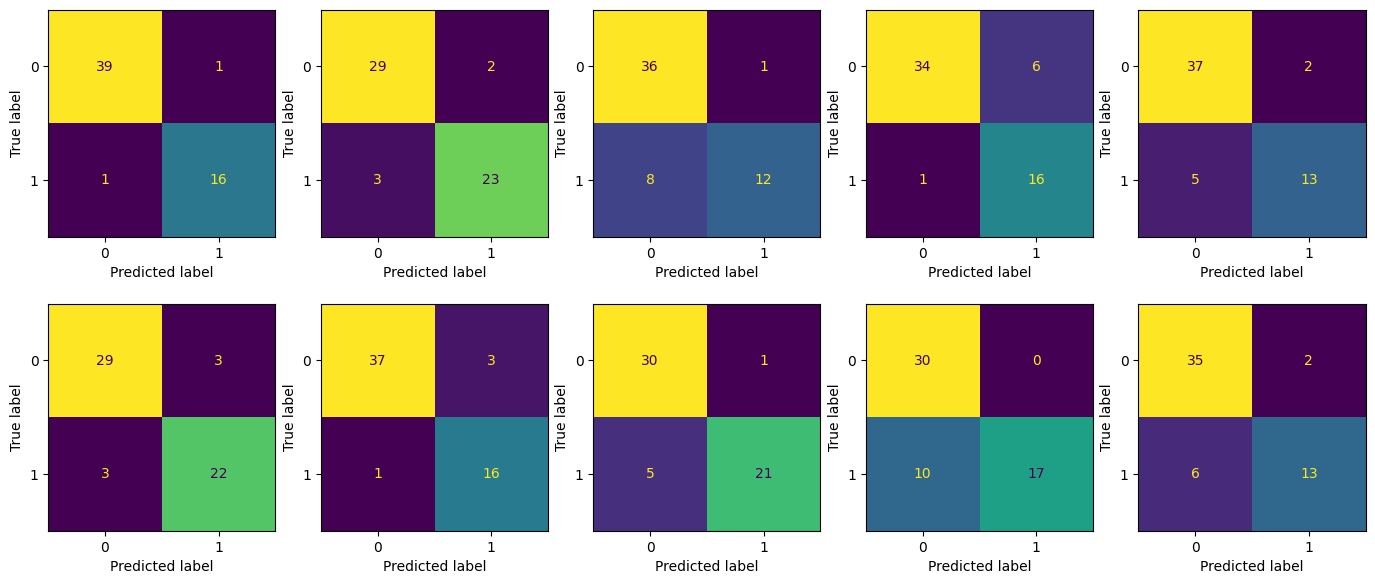

In [21]:
row=0
col=0
fig, ax = plt.subplots(2, 5)
for i in lstm_matrix:
    fig.set_figwidth(17)
    fig.set_figheight(7) 
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = i, display_labels = [0, 1]).plot(ax=ax[col][row],colorbar=False)

    row+=1
    if(row==5):
        col=1
        row=0
print("--------------------------Long Short Term Memory--------------------------")

<h3>6.1) Average and Results for K Nearest Neighbor</h3>
Once each of the k-fold iterations has been completed, a confusion matrix using the average of the each iteration's confusion matrix is then created and used to calculate the average of each of the scoring metrics which is then appended to the end of the dataframe. For Brier score and AUC, the average of each score is calculated and sent to the calculation function as well. Finally each of the columns is labled to indicate which fold it is from and then printed out. 


----K Nearest Neighbor----
             fold_1  fold_2  fold_3  fold_4  fold_5  fold_6  fold_7  fold_8  \
TP            39.00   31.00   36.00    40.0   37.00   29.00   39.00   31.00   
TN            16.00   23.00   20.00    17.0   12.00   21.00   16.00   19.00   
FP             1.00    0.00    1.00     0.0    2.00    3.00    1.00    0.00   
FN             1.00    3.00    0.00     0.0    6.00    4.00    1.00    7.00   
TPR            0.98    0.91    1.00     1.0    0.86    0.88    0.98    0.82   
TNR            0.94    1.00    0.95     1.0    0.86    0.88    0.94    1.00   
FPR            0.06    0.00    0.05     0.0    0.14    0.12    0.06    0.00   
FNR            0.02    0.09    0.00     0.0    0.14    0.12    0.02    0.18   
Precision      0.98    1.00    0.97     1.0    0.95    0.91    0.98    1.00   
Accuracy       0.96    0.95    0.98     1.0    0.86    0.88    0.96    0.88   
Recall         0.98    0.91    1.00     1.0    0.86    0.88    0.98    0.82   
F1_measure     0.98    0

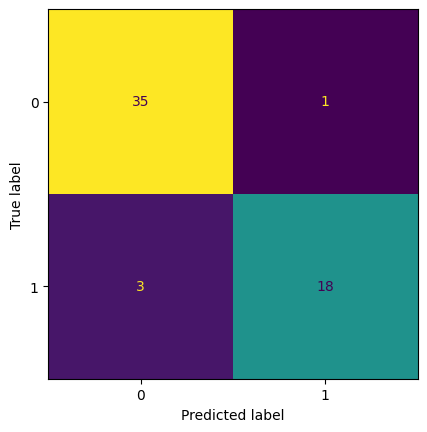

In [22]:
#KNN average
knn_mean_of_conf_matrix_arrays = np.mean(knn_matrix, axis=0)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = knn_mean_of_conf_matrix_arrays, display_labels = [0, 1]).plot(colorbar=False)
flipped=knn_metrics_list.T
Brier_total = flipped.loc["Brier_Score"]
Brier_avg=0
for val in Brier_total:
    Brier_avg+=val
Brier_avg=Brier_avg/10
auc_total=flipped.loc["AUC"]
auc_avg=0
for val in auc_total:
    auc_avg+=val
auc_avg=auc_avg/10
knn_metrics_list=pd.concat([knn_metrics_list,Calculations(knn_mean_of_conf_matrix_arrays,Brier_avg,0,True,auc_avg)])
knn_metrics_list.index=['fold_1','fold_2','fold_3','fold_4','fold_5','fold_6','fold_7','fold_8','fold_9','fold_10','Mean']
print("\n----K Nearest Neighbor----")
print(knn_metrics_list.T.round(decimals=2))


<h3>6.2) Average and Results for Random Forest</h3>
Once each of the Random forest iterations has been completed, a confusion matrix using the average of the each iteration's confusion matrix is then created and used to calculate the average of each of the scoring metrics which is then appended to the end of the dataframe. For Brier score and AUC, the average of each score is calculated and sent to the calculation function as well. Finally each of the columns is labled to indicate which fold it is from and then printed out. 


----Random Forest----
             fold_1  fold_2  fold_3  fold_4  fold_5  fold_6  fold_7  fold_8  \
TP            39.00   31.00    37.0   39.00   38.00   31.00   39.00   30.00   
TN            16.00   24.00    20.0   17.00   17.00   23.00   17.00   25.00   
FP             1.00    0.00     0.0    1.00    1.00    1.00    1.00    1.00   
FN             1.00    2.00     0.0    0.00    1.00    2.00    0.00    1.00   
TPR            0.98    0.94     1.0    1.00    0.97    0.94    1.00    0.97   
TNR            0.94    1.00     1.0    0.94    0.94    0.96    0.94    0.96   
FPR            0.06    0.00     0.0    0.06    0.06    0.04    0.06    0.04   
FNR            0.02    0.06     0.0    0.00    0.03    0.06    0.00    0.03   
Precision      0.98    1.00     1.0    0.98    0.97    0.97    0.98    0.97   
Accuracy       0.96    0.96     1.0    0.98    0.96    0.95    0.98    0.96   
Recall         0.98    0.94     1.0    1.00    0.97    0.94    1.00    0.97   
F1_measure     0.98    0.97  

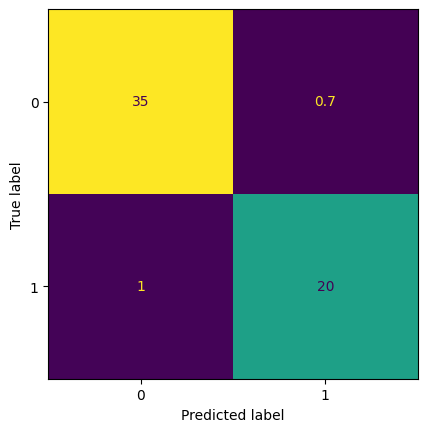

In [23]:
#Random Forest average
rf_mean_of_conf_matrix_arrays = np.mean(rf_matrix, axis=0)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = rf_mean_of_conf_matrix_arrays, display_labels = [0, 1]).plot(colorbar=False)
flipped=rf_metrics_list.T
Brier_total = flipped.loc["Brier_Score"]
Brier_avg=0
for val in Brier_total:
    Brier_avg+=val
Brier_avg=Brier_avg/10
auc_total=flipped.loc["AUC"]
auc_avg=0
for val in auc_total:
    auc_avg+=val
auc_avg=auc_avg/10
rf_metrics_list=pd.concat([rf_metrics_list,Calculations(rf_mean_of_conf_matrix_arrays,Brier_avg,0,True,auc_avg)])
rf_metrics_list.index=['fold_1','fold_2','fold_3','fold_4','fold_5','fold_6','fold_7','fold_8','fold_9','fold_10','Mean']
print("\n----Random Forest----")
print(rf_metrics_list.T.round(decimals=2))


<h3>6.3) Average and Results for Long Short Term Memory</h3>
Once each of the Long Short Term Memory iterations has been completed, a confusion matrix using the average of the each iteration's confusion matrix is then created and used to calculate the average of each of the scoring metrics which is then appended to the end of the dataframe. For Brier score and AUC, the average of each score is calculated and sent to the calculation function as well. Finally each of the columns is labled to indicate which fold it is from and then printed out. 


----Long Short Term Memory----
             fold_1  fold_2  fold_3  fold_4  fold_5  fold_6  fold_7  fold_8  \
TP            39.00   29.00   36.00   34.00   37.00   29.00   37.00   30.00   
TN            16.00   23.00   12.00   16.00   13.00   22.00   16.00   21.00   
FP             1.00    2.00    1.00    6.00    2.00    3.00    3.00    1.00   
FN             1.00    3.00    8.00    1.00    5.00    3.00    1.00    5.00   
TPR            0.98    0.91    0.82    0.97    0.88    0.91    0.97    0.86   
TNR            0.94    0.92    0.92    0.73    0.87    0.88    0.84    0.95   
FPR            0.06    0.08    0.08    0.27    0.13    0.12    0.16    0.05   
FNR            0.02    0.09    0.18    0.03    0.12    0.09    0.03    0.14   
Precision      0.98    0.94    0.97    0.85    0.95    0.91    0.92    0.97   
Accuracy       0.96    0.91    0.84    0.88    0.88    0.89    0.93    0.89   
Recall         0.98    0.91    0.82    0.97    0.88    0.91    0.97    0.86   
F1_measure     0.98 

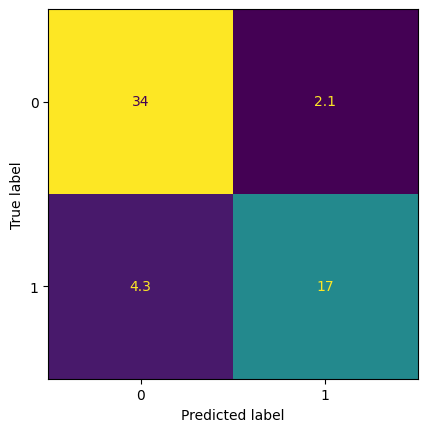

In [24]:
#LSTM average
lstm_mean_of_conf_matrix_arrays = np.mean(lstm_matrix, axis=0)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = lstm_mean_of_conf_matrix_arrays, display_labels = [0, 1]).plot(colorbar=False)
flipped=lstm_metrics_list.T
Brier_total = flipped.loc["Brier_Score"]
Brier_avg=0
for val in Brier_total:
    Brier_avg+=val
Brier_avg=Brier_avg/10
auc_total=flipped.loc["AUC"]
auc_avg=0
for val in auc_total:
    auc_avg+=val
auc_avg=auc_avg/10
lstm_metrics_list=pd.concat([lstm_metrics_list,Calculations(lstm_mean_of_conf_matrix_arrays,Brier_avg,0,True,auc_avg)])
lstm_metrics_list.index=['fold_1','fold_2','fold_3','fold_4','fold_5','fold_6','fold_7','fold_8','fold_9','fold_10','Mean']
print("\n----Long Short Term Memory----")
print(lstm_metrics_list.T.round(decimals=2))

<h3>7) Results Analysis</h3>
Now that all 3 dataframes and confusion matrixes have been completed, the results can be compared. this is done by extracting the column labled "MEAN" from each of the 3 individual dataframes and then combined into one large dataframe.

             KNN_AVG  RF_AVG  LSTM_AVG
TP             34.70   35.00     33.60
TN             18.20   20.20     16.90
FP              1.00    0.70      2.10
FN              3.00    1.00      4.30
TPR             0.92    0.97      0.89
TNR             0.95    0.97      0.89
FPR             0.05    0.03      0.11
FNR             0.08    0.03      0.11
Precision       0.97    0.98      0.94
Accuracy        0.93    0.97      0.89
Recall          0.92    0.97      0.89
F1_measure      0.95    0.98      0.91
Error_rate      0.07    0.03      0.11
BACC            0.93    0.97      0.89
TSS             0.87    0.94      0.78
HSS             1.63    1.81      1.37
Brier_Score     0.07    0.03      0.11
AUC             0.92    0.97      0.95


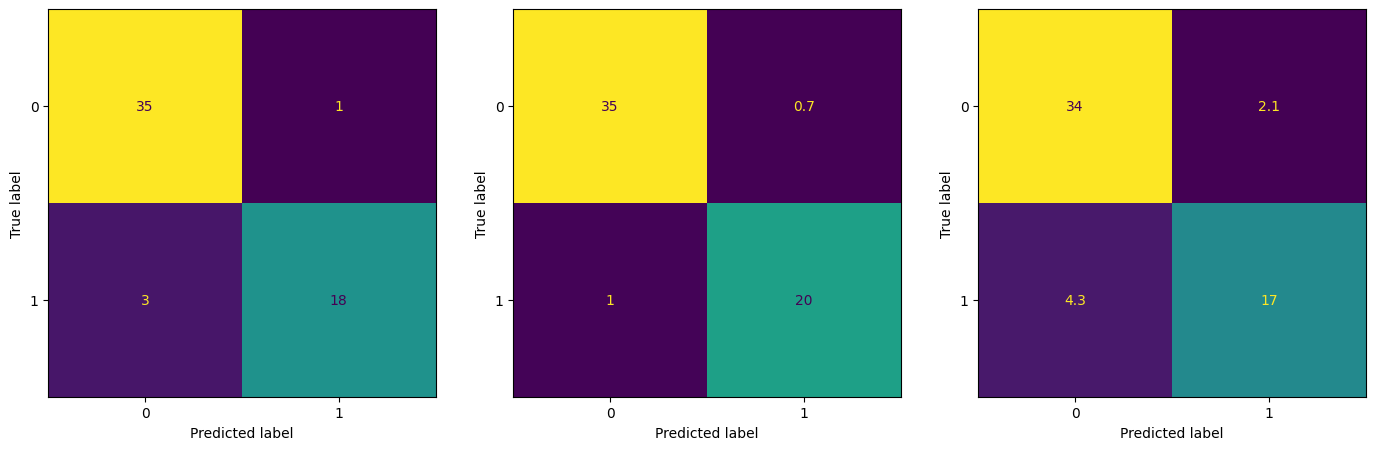

In [25]:
fig, ax = plt.subplots(1, 3)
fig.set_figwidth(17)
fig.set_figheight(7)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = knn_mean_of_conf_matrix_arrays, display_labels = [0, 1]).plot(ax=ax[0],colorbar=False)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = rf_mean_of_conf_matrix_arrays, display_labels = [0, 1]).plot(ax=ax[1],colorbar=False)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = lstm_mean_of_conf_matrix_arrays, display_labels = [0, 1]).plot(ax=ax[2],colorbar=False)
mean=pd.DataFrame()
mean = pd.concat([mean, knn_metrics_list.loc["Mean"].rename("KNN_AVG")], axis=1)
mean = pd.concat([mean, rf_metrics_list.loc["Mean"].rename("RF_AVG")], axis=1)
mean = pd.concat([mean, lstm_metrics_list.loc["Mean"].rename("LSTM_AVG")], axis=1)
print(mean.round(decimals=2))


<h3>8) Results Analysis</h3>
After analyzing the three models from K-Nearest Neighbor (KNN), Random Forest (RF), and Long Short Term Memory (LSTM) we can conclude that <strong>Random Forest created the best model</strong>. looking at the dataframe above containing the average scoring metric from each model, we can see that both KNN and LSTM have a false positive above 2 and a false negative above 3 while RF has a false positive of 0.8 and a false negative of 1.2. this results in the Random Forest model having a higher precision, accuracy, and AUC while also having a lower error rate and brier score, both of which are a positive attributes. Random Forest also has a higher TPR and TNR, and a lower FPR and FNR which both 